In [1]:
#importing relevant libraries

import pickle
import numpy as np
import pandas as pd
import os
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import random


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
root_dir = 'gdrive/My\ Drive/Research/Codes/LSTM'
data_dir = 'gdrive/MyDrive/Research/Codes/data/'

# Reading Data

In [4]:
# reading MIDI files
def read_midi(file):    
    # print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    instruments = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in instruments.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [5]:
#reading file names
files=[i for i in os.listdir(data_dir) if i.endswith(".mid")]

#reading each file
notes_array = np.array([read_midi(data_dir+i) for i in files])


<ipython-input-5-393c5270a020>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi(data_dir+i) for i in files])


# Understanding & Preprocessing Data

In [6]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

396


(array([303.,  32.,  14.,  10.,   9.,   7.,   5.,   7.,   4.,   5.]),
 array([1.0000e+00, 1.4610e+02, 2.9120e+02, 4.3630e+02, 5.8140e+02,
        7.2650e+02, 8.7160e+02, 1.0167e+03, 1.1618e+03, 1.3069e+03,
        1.4520e+03]),
 <BarContainer object of 10 artists>)

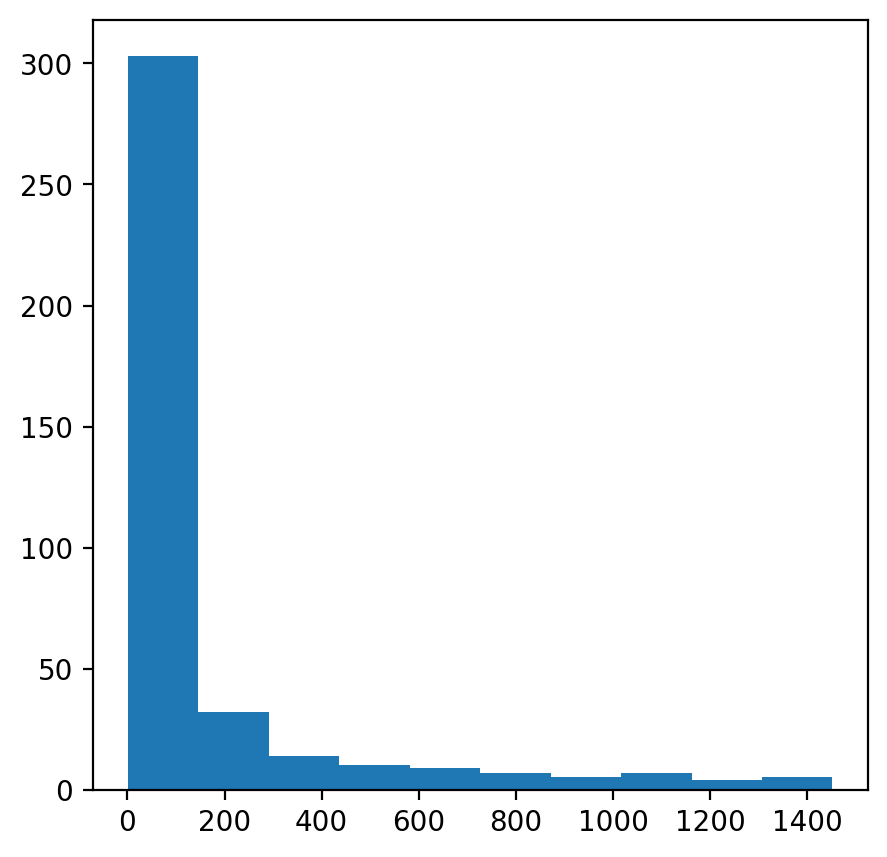

In [7]:
#distribution of notes

#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [8]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

137


In [9]:
#top frequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

<ipython-input-9-87511c7a181a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_music = np.array(new_music)


## Preparation of input & output sequences

In [10]:
#prepping data
no_of_timesteps = 128
n_vocab = len(set(frequent_notes))
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        # print(note_)
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)


x=np.array(x)
y=np.array(y)

In [11]:
#encoding notes
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))


In [12]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)

print(x_seq)
#reshaping
x_seq = np.reshape(x_seq, (len(x_seq), no_of_timesteps, 1))
#normalizing the inputs
x_seq = x_seq / float(n_vocab) 

x_seq = np.array(x_seq)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
#encoding notes of the output sequence
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

#reshaping
y_seq = np.reshape(y_seq,(-1,1))


In [14]:
# splitting data for training and testing
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)


# Model Creation

In [15]:
def wavenet():
  no_of_kernels=128
  num_of_blocks= int(np.sqrt(no_of_timesteps)) - 1   #no. of stacked conv1d layers
  model = Sequential()
  for i in range(num_of_blocks):
    model.add(Conv1D(no_of_kernels,3,dilation_rate=(2**i),padding='causal',activation='relu'))
  model.add(Conv1D(1, 1, activation='relu', padding='causal'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_vocab, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [16]:
#creating checkpoint
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)


In [17]:
model = wavenet()
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=256,epochs=100, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])


Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 4.6029
Epoch 1: val_loss improved from inf to 4.53943, saving model to best_model.h5
138/138 [==============================] - 32s 153ms/step - loss: 4.6029 - val_loss: 4.5394
Epoch 2/100
137/138 [============================>.] - ETA: 0s - loss: 4.5487
Epoch 2: val_loss improved from 4.53943 to 4.53864, saving model to best_model.h5
138/138 [==============================] - 15s 112ms/step - loss: 4.5487 - val_loss: 4.5386
Epoch 3/100
138/138 [==============================] - ETA: 0s - loss: 4.5469
Epoch 3: val_loss improved from 4.53864 to 4.53431, saving model to best_model.h5
138/138 [==============================] - 16s 113ms/step - loss: 4.5469 - val_loss: 4.5343
Epoch 4/100
137/138 [============================>.] - ETA: 0s - loss: 4.5420
Epoch 4: val_loss improved from 4.53431 to 4.52568, saving model to best_model.h5
138/138 [==============================] - 15s 112ms/step - loss: 4.5422 - val_loss: 4.5

In [26]:
#loading best model
model = load_model('best_model.h5')

# Generating Sequences

In [45]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

1/1 [==============================] - 0s 32ms/step
[62, 1, 1, 28, 81, 106, 106, 71, 20, 28]


In [46]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [47]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    fp = 'musicwavenet' + str(random.randint(0, 1000000000000000)) + '.mid'
    midi_stream.write('midi', fp=fp)

In [48]:
print(predicted_notes)

['2.6', 'G3', 'G3', 'B2', 'B3', 'A2', 'A2', 'E-3', 'F2', 'B2']


In [49]:
convert_to_midi(predicted_notes)


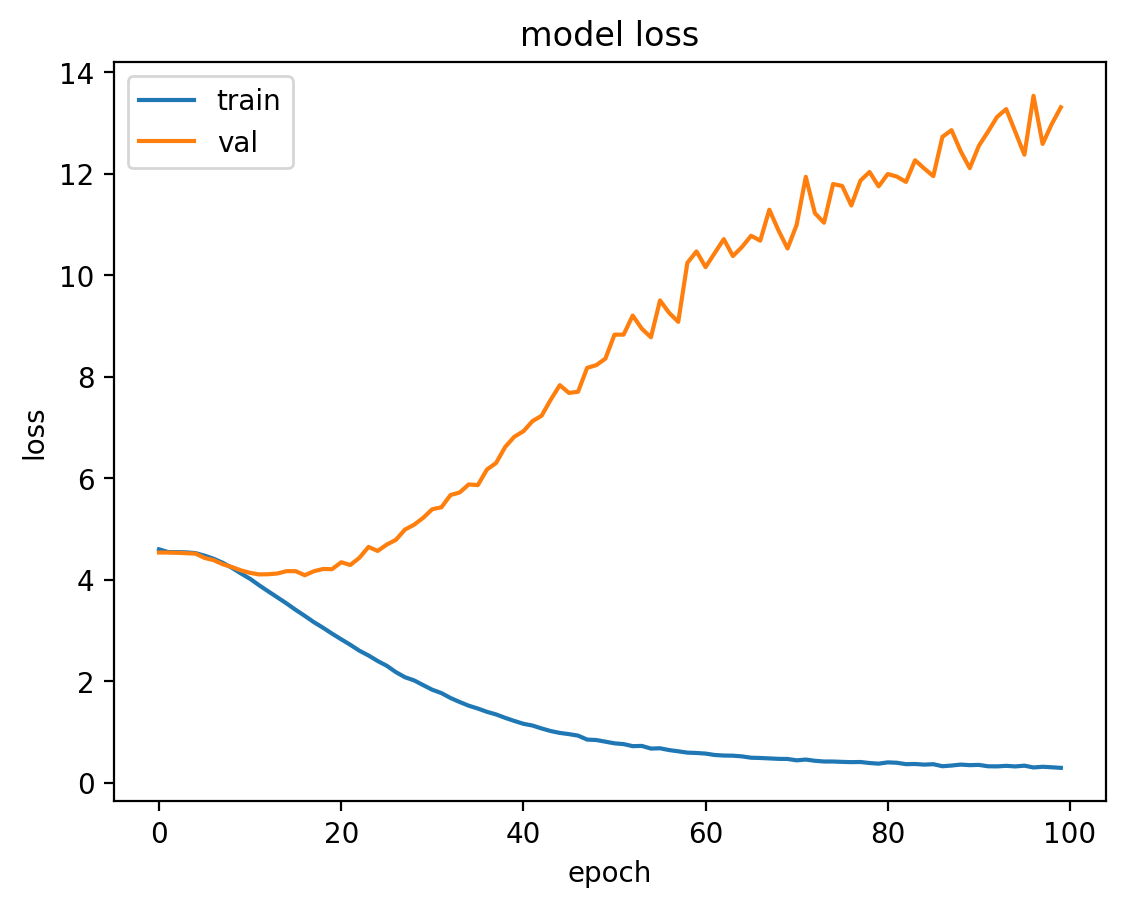

In [44]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 128)          512       
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 conv1d_6 (Conv1D)           (None, 128, 128)          4